In [1]:
from astropy.io import fits
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import math

In [2]:
hsc_dir_name = '/data/des90.a/data/jsanch87/HSC/PDR2/'
hsc_files = ['HSC_i_lt_22.fits',\
             'HSC_22_i_22p5.fits',\
             'HSC_23p5_i_24p5.fits',\
             'HSC_24p5_i_25.fits']

delve_dir_name = '/data/des91.b/data/kadrlica/projects/delve/cat/y2t1/r1/cat/'
delve_base_file_name = 'cat_hpx_'
delve_ext = '.fits'

delve_pixel_list_dir_name = '/home/sr1/djsuson/'
delve_pixel_list_file_name = 'delve_pix_list.txt'

In [3]:
bright_mag = 27
dim_mag = 1
lower_spread_limit = -0.025
upper_spread_limit = 0.045
min_ext = 0.003
wide_ext = 0.005
max_sep = 0.5 * u.arcsec
debug = False
nSides = 32
channel = 'i'

In [4]:
def set_mag_limits(data, bright, dim):
  true_mags = [mag for mag in data[f'{channel}_cmodel_mag'] if np.isnan(mag) == False]
  good_mags = [mag for mag in true_mags if mag < 35]
  if np.min(good_mags) < bright:
    upper = np.min(good_mags)
  if np.max(good_mags) > dim:
    lower = np.max(good_mags)

  return upper, lower

In [5]:
def calc_matches(delve_ds, hsc_ds):
  if (len(delve_ds) > 0) & (len(hsc_ds) > 0):
    delve_sky = SkyCoord(ra=delve_ds['ra']*u.degree,dec=delve_ds['dec']*u.degree)    
    hsc_sky = SkyCoord(ra=hsc_ds['ra']*u.degree,dec=hsc_ds['dec']*u.degree)
    idx, d2d, d3d = match_coordinates_sky(delve_sky, hsc_sky)
    sep_constraint = d2d < max_sep
    delve_matches = delve_ds[sep_constraint]
    fraction = len(delve_matches) / len(delve_ds)
  else:
    delve_matches = []
    fraction = 0.0
  if debug == True:
    print(f'Fraction of delve galaxies that are also in {hsc_file_name} at pixel {pixel}: {fraction}')
  return delve_matches

In [6]:
hsc_combined_data = []

# Get overlapping pixel list
delve_pixel_fqpn = delve_pixel_list_dir_name + delve_pixel_list_file_name
delve_pixel_list = np.genfromtxt(delve_pixel_fqpn)
hsc_hdul = fits.open(hsc_dir_name+hsc_files[0], memmap=True)
hsc_data = hsc_hdul[1].data

# Generate combined HSC catalog for selected pixel
for hsc_file_name in hsc_files:
  hsc_fqpn = hsc_dir_name + hsc_file_name
  hsc_hdul = fits.open(hsc_fqpn, memmap=True)

  hsc_data = hsc_hdul[1].data

  # Determine pixel for each HSC object
  hsc_pixel = hp.ang2pix(nSides,hsc_data['ra'],hsc_data['dec'],lonlat=True)
  hsc_pixel_list = np.unique(hsc_pixel)
#  indices = (hsc_pixel == pixel)
#  hsc_pix_objs = hsc_data[indices]

  # Add to combined data list
  if len(hsc_combined_data) == 0:
    hsc_combined_data = hsc_pix_objs
  else:
    hsc_combined_data = np.concatenate([hsc_combined_data,hsc_pix_objs])

  if debug == True:
    print('HSC data size: ', len(hsc_combined_data))
    
  hsc_hdul.close()

bright_mag, dim_mag = set_mag_limits(hsc_combined_data, bright_mag, dim_mag)

# Open Delve pixel
delve_fqpn = delve_dir_name + delve_base_file_name + str(pixel) + delve_ext
delve_hdul = fits.open(delve_fqpn, memmap=True)
delve_data = delve_hdul[1].data

# Eliminate Delve objects outside of magnitude range
indices = (delve_data[f'mag_auto_{channel}'] > bright_mag) & (delve_data[f'mag_auto_{channel}'] < dim_mag)
delve_pix_objs = delve_data[indices]

delve_hsc = calc_matches(delve_pix_objs,hsc_combined_data)
delve_hdul.close()

/tmp/ipykernel_31641/1975308322.py:8: RuntimeWarning: invalid value encountered in true_divide
  ratio = 1.0 * hist_match / hist_full


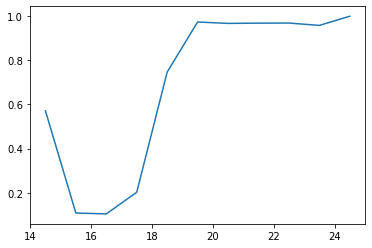

In [7]:
# plot ratio of Delve objects found in HSC database
match = delve_hsc[f'mag_auto_{channel}']
full = delve_pix_objs[f'mag_auto_{channel}']
low_range = math.floor(bright_mag - 1.0)
high_range = math.ceil(dim_mag + 1.0)
hist_match, bin_edges_match = np.histogram(match,range=(low_range,high_range),bins=high_range-low_range)
hist_full, bin_edges_full = np.histogram(full,range=(low_range,high_range),bins=high_range-low_range)
ratio = 1.0 * hist_match / hist_full
bin_centers = 0.5 * bin_edges_match[1:] + 0.5 * bin_edges_match[:-1]
plt.plot(bin_centers,ratio)